In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### READ IN THE DATA

In [64]:
df = pd.read_csv('https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/raw/master/perrin-freres-monthly-champagne-.csv')
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [66]:
df = df.dropna()
df.shape

(105, 2)

In [67]:
# Rename column
df.rename({'Perrin Freres monthly champagne sales millions ?64-?72': 'sales'}, axis=1, inplace=True)

In [68]:
df.head(10)

,Month,sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
5,1964-06,3036.0
6,1964-07,2282.0
7,1964-08,2212.0
8,1964-09,2922.0
9,1964-10,4301.0


In [69]:
# Covert Month into datetime 
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head()

,sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [70]:
# Descriptive statistics
df.describe()

,sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


### Data Visualization

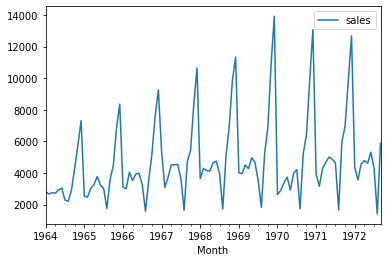

In [71]:
df.plot()

#### We see that, visually the data is not stationary and has some seasonal element to it. We will first make the data stationary first.

In [72]:
# Test for stationarity
from statsmodels.tsa.stattools import adfuller

In [73]:
#h0 : non stationary
#h1: stationary

def adfuller_test(data):
    results = adfuller(data)
    labels =['Test Statistic', 'p-value', '#Lags Used', '#Obs']
    for value, label in zip(results, labels):
        print(label + ': ' + str(value))
    
    if results[1] <= 0.05:
        print('Reject Null Hypothesis')
    else:
        print('Fail to reject null hypothesis')
adfuller_test(df)

Test Statistic: -1.8335930563276193
p-value: 0.36391577166024686
#Lags Used: 11
#Obs: 93
Fail to reject null hypothesis


#### Now it is confirmed that the time series is non stationary. In order to make the time series stationary, we use a technique called diffrencing.

In [74]:
df['sales_first_difference'] = df['sales'] - df['sales'].shift(1)
df['sales_seasonal_difference'] = df['sales'] - df['sales'].shift(12)
df.head()

,sales,sales_first_difference,sales_seasonal_difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [84]:
adfuller_test(df['sales_seasonal_difference'].dropna())

Test Statistic: -7.626619157213166
p-value: 2.0605796968136632e-11
#Lags Used: 0
#Obs: 92
Reject Null Hypothesis


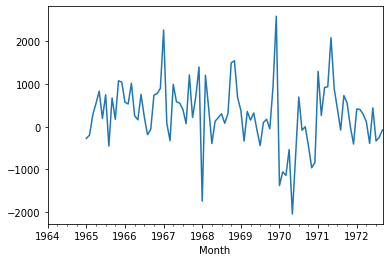

In [85]:
df['sales_seasonal_difference'].plot()

#### Now the next step is to identify the type of time series model. For that we use ACF and PACF plot. ACF plot tels us about  the MA component and PACF tells us about the AR component

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

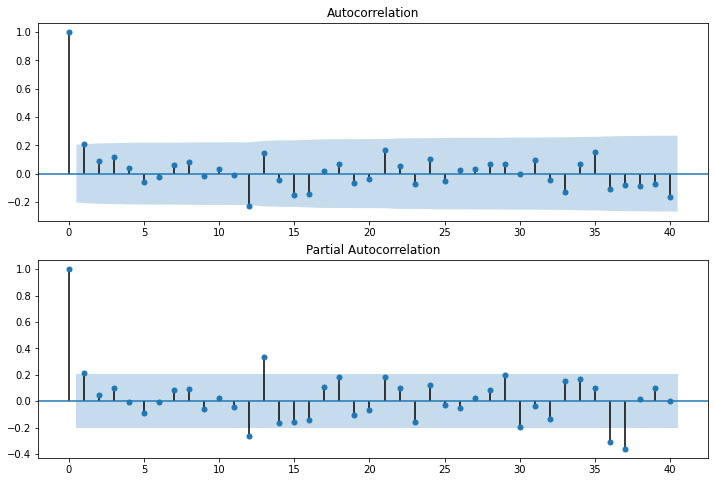

In [91]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['sales_seasonal_difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['sales_seasonal_difference'].iloc[13:], lags=40, ax=ax2)


#### From the PACF plot, we find that the PACF immediately shuts after lag 1. The same is the scenario for ACF plot. THerefore we can say that it is an ARMA(1,1,1) i.e p=1, d=1, q=1

In [93]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df['sales'], order=(1,1,1)).fit()

/home/gagandeep/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/gagandeep/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [94]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Fri, 17 Jul 2020   AIC                           1910.251
Time:                        22:36:37   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7846     12.405      1.837      0.066      -1.529      47.098
ar.L1.D.sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [96]:
import statsmodels.api as sm
model_sm = sm.tsa.statespace.SARIMAX(df['sales'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

/home/gagandeep/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/gagandeep/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [97]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Fri, 17 Jul 2020   AIC                           1486.804
Time:                                    22:47:02   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### On analyzing the AIC and BIC of both the model, we conclude that the second model is better due to lower values of AIC and BIC. Now predicting the future values based on test data

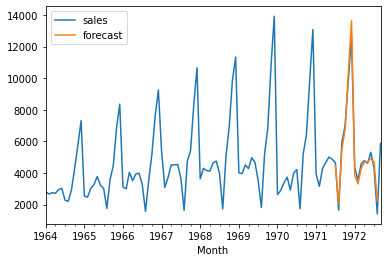

In [99]:
df['forecast'] = model_sm.predict(start=90, end=103, dynamic=True)
df[['sales', 'forecast']].plot()

In [101]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24)]
future_df = pd.DataFrame(index=future_dates[1:], columns=df.columns)
future_df.head()

,sales,sales_first_difference,sales_seasonal_difference,forecast
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN


#### Making future predictions

In [103]:
future_df = pd.concat([df, future_df])
future_df.tail()

,sales,sales_first_difference,sales_seasonal_difference,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


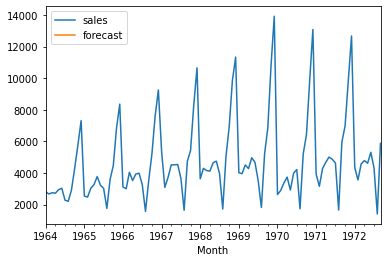

In [104]:
df['forecast'] = model_sm.predict(start=104, end=120, dynamic=True)
df[['sales', 'forecast']].plot()